In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Visualize the keypoint's location and orientation + descriptor regions and orientations

Load the selected keypoint and descriptor of a given batch; then, visualize 
1. The keypoint's location
2. A given descriptor element's region, and 
3. orientation (absolute and relative to the keypoint's orientation)

In [2]:
# set user given parameters
batch_ind = 450
desel_ind = 750
batch_sz = 32
data_path = '../../data/features/sift3d/fvs_s1_with_kp/'
save_id = '_1' # add to the filenames whenever we save any data in this notebook

assert batch_ind >= 0 and batch_ind <= 1140
assert desel_ind >= 0 and desel_ind <= 768

# load a given batch's keypoint and descriptor
desc = np.loadtxt(data_path+'desc/fv_'+str(batch_ind)+'.csv', delimiter=',')
keyp = np.loadtxt(data_path+'keys/fv_'+str(batch_ind)+'.csv', delimiter=',')
print(desc.shape)
print(keyp.shape)
print(keyp)

(768,)
(14,)
[ 4.0000000e+00  1.3000000e+01  2.3000000e+01  2.0000000e+00
  1.0159367e+01 -8.1930000e-03 -1.4070000e-03 -9.9996500e-01
 -9.8990100e-01 -1.4152000e-01  8.3100000e-03 -1.4152600e-01
  9.8993400e-01 -2.3300000e-04]


**Descriptor format (based on the paper):**
<br>
[x, y, z, el0, el1, ..., el767]
<br>
Each row is a single feature descriptor.
<br>
[x, y, z] are the keypoint's coordinates in 3D-image space, and [el0, el1, ..., el767] are the 768 dimensions of the descriptor.

*Note:* Here, the first three elements (i.e. the x, y, z) are removed since they are repeated in the keypoint's vector anyway.

**Keypoint format (based on the paper):**
<br>
Each row is a keypoint. The elements of each row are as follows:
<br>
[x, y, z, o, s, $ori_{11}, ori_{12}, ..., ori_{nn}$]
<br>
x - the x-coordinate
<br>
y - the y-coordinate
<br>
z - the z-coordinate
<br>
o - the pyramid octave. To convert to image coordinates, multiply x,y,z by pow(2, o)
<br>
s - the scale coordinate
<br>
$ori_{ij}$ - the ith row, jth column of the orientation matrix

*Note:* We know that the first three elements are actually z,y,x based on the toy example in the following notebook:
<br>
code/17_interpretation/04_examin_sift3d_kp_coordinates.ipynb

## Visualize the keypoint's location

Draw a circle in the exact (x,y,z) location assigned to the keypoint.

In [3]:
# load the fish movie frames
fdata_path = '../../../local_data/original_files/frames.csv'
frames = np.loadtxt(fdata_path, delimiter=',')
frames = frames.reshape(frames.shape[0], 120, 200)
print('frames.shape = {}'.format(frames.shape))

frames.shape = (1141, 120, 200)


In [4]:
# construct the given frame batch
idx = np.arange(batch_ind-batch_sz+1, batch_ind+1, dtype=np.int32)
print('chosen frame indices: ', idx)
sample_batch = frames[idx]
print('sample_batch.shape = {}'.format(sample_batch.shape))

chosen frame indices:  [419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436
 437 438 439 440 441 442 443 444 445 446 447 448 449 450]
sample_batch.shape = (32, 120, 200)


In [5]:
# compute the keypoint's location in the frame batch
img_coor = lambda keyp, coor_i: int(keyp[coor_i] * (2**keyp[3]))
kp_z = img_coor(keyp, 0)
kp_y = img_coor(keyp, 1)
kp_x = img_coor(keyp, 2)
kp_s = keyp[4]
print('Location of the keypoint (z, y, x, s):', (kp_z, kp_y, kp_x, kp_s))

Location of the keypoint (z, y, x, s): (16, 52, 92, 10.159367)


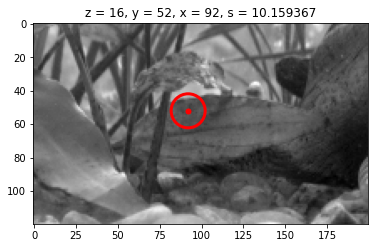

In [6]:
# draw a circle around the keypoint's location
fig, ax = plt.subplots()
plt.imshow(sample_batch[kp_z], cmap='gray')
# plt.axis("off")
# plt.axis("equal")
circle1 = plt.Circle((kp_x,kp_y), kp_s, color='r', fill=False, linewidth=3)
ax.add_patch(circle1)
ax.plot((kp_x), (kp_y), 'o', color='r', markersize=5)
plt.title('z = {}, y = {}, x = {}, s = {}'.format(kp_z, kp_y, kp_x, kp_s))
plt.savefig('image/keypoint_fv_'+str(desel_ind)+'_batch_'+str(batch_ind)+save_id+'.png',dpi=300, bbox_inches = "tight")

## Mark a descriptor element's region

Color in red the region of a given element of the descriptor.
<br>

**Relative Coordinates (z,y,x) and orientation:**
<br>
The relative coordinates are transferred by the keypoint's location vector and rotated by the keypoint's orientation matrix.
<br>
The relative orientation is given by the number of the corresponding vertex in the regular icosahedron. The icosahedron is also rotated by the keypoint's orientation matrix.

**Size of the neighborhood around the keypoint:**
<br>
The size of the whole neighborhood is $2 \sigma$ where $\sigma$ is the standard deviation of the utilized Gaussian filter, based on B. Rister's paper which introduces the current 3D-SIFT code.
<br>
Since this neighborhood is chupped to $4 \times 4 \times 4$ smaller equal-sized regions, the size of each region is $0.5 \sigma$.
<br>

**Region of a descriptor element:**
<br>
Regions are number -2, -1, 0, 1 in the paper; hence, that is how we number them here.
<br>
Hence, a region's pixel range in the rotated coordinates is computed by the following formula:
<br>
$i (0.5 \sigma): (i+1) (0.5 \sigma)$ 
<br>
where $i$ is the region's number (aka coordinate) in the desired axis (z, y, x).
<br>
To convert this range to the unrotated coordinate system, we should multiply the range by the rotated axis vectors in the unrotated system, and transfer the whole range by the keypoint's location vector. 

In [7]:
kp_loc = np.array([kp_z, kp_y, kp_x])
kp_ori = keyp[5:].reshape((3,3))
win_rad = 2*kp_s # radius of the sphere around the keypoing where the descriptor is computed
region_side = win_rad/np.sqrt(2)/2
print('Location of the keypoint (z, y, x):', kp_loc)
print('Orientation of the keypoint:\n', kp_ori)
print('Radius of the neighborhood to compute the descriptor:', win_rad)
print('Size of a side of a region:', region_side)

Location of the keypoint (z, y, x): [16 52 92]
Orientation of the keypoint:
 [[-8.19300e-03 -1.40700e-03 -9.99965e-01]
 [-9.89901e-01 -1.41520e-01  8.31000e-03]
 [-1.41526e-01  9.89934e-01 -2.33000e-04]]
Radius of the neighborhood to compute the descriptor: 20.318734
Size of a side of a region: 7.183757298262831


In [8]:
# pick a descriptor element and call it desel
print('Decriptor element #{} is {}'.format(desel_ind, desc[desel_ind]))

Decriptor element #750 is 0.047031


In [9]:
# compute desel's region coordinates relative to the keypoint
desel_ori_rel = desel_ind%12 # 12 vertices of icosahedron
desel_z_rel = desel_ind//12%4 - 2 # z comes first based on the toy example results. -2 shifts the indices to -2 to 1 range.
desel_y_rel = desel_ind//12//4%4 - 2
desel_x_rel = desel_ind//12//4//4 - 2
desel_loc_rel = np.array([desel_z_rel, desel_y_rel, desel_x_rel])
print('Relative location of desel region (z, y, x):', desel_loc_rel)
print('Corresponding icosahedron vertex of desel:', desel_ori_rel)

Relative location of desel region (z, y, x): [0 1 1]
Corresponding icosahedron vertex of desel: 6


In [10]:
# compute the coordinates of the region's corners in the original coordinate system
corners1_zyx = np.broadcast_to(desel_loc_rel[np.newaxis, :], (3,3)) * kp_ori * region_side
corner1 = np.sum(corners1_zyx, axis=1, keepdims=False) + kp_loc
deltas = kp_ori*region_side

print('First corner:\n', corner1)
print('\nRange determinators along three orthogonal axes (delta_z_hat, delta_y_hat, delta_x_hat):\n', deltas)

First corner:
 [ 8.80638659 51.04305169 99.10977178]

Range determinators along three orthogonal axes (delta_z_hat, delta_y_hat, delta_x_hat):
 [[-5.88565235e-02 -1.01075465e-02 -7.18350587e+00]
 [-7.11120853e+00 -1.01664533e+00  5.96970231e-02]
 [-1.01668844e+00  7.11144560e+00 -1.67381545e-03]]


In [11]:
def discretize(start, stop):
    """
    Discretize a line into points on the coordinate gridlines.
    """
    diff = stop - start
    diff_unit = diff / np.linalg.norm(diff)
    num_pts = int(np.floor(np.linalg.norm(diff)))
    
    disc_pts = start.copy()
    disc_pts = disc_pts[:, np.newaxis]
    for i in range(num_pts):
        endi = start + (i+1)*diff_unit
        disc_pts = np.append(disc_pts, endi[:,np.newaxis], axis=1)
        
    return np.round(disc_pts)

In [12]:
# discretize the delta vectors into a list of points with whole numbers as coordinates
start = np.zeros(3)
disc_z = discretize(start, deltas[:,0])
disc_y = discretize(start, deltas[:,1])
disc_x = discretize(start, deltas[:,2])

# discretize the location of the corner of the region
disc_corner1 = np.round(corner1)

print('delta_z_hat list:\n', disc_z)
print('delta_y_hat list:\n', disc_y)
print('delta_x_hat list:\n', disc_x)
print('corner:\n', disc_corner1)

delta_z_hat list:
 [[ 0. -0. -0. -0. -0. -0. -0. -0.]
 [ 0. -1. -2. -3. -4. -5. -6. -7.]
 [ 0. -0. -0. -0. -1. -1. -1. -1.]]
delta_y_hat list:
 [[ 0. -0. -0. -0. -0. -0. -0. -0.]
 [ 0. -0. -0. -0. -1. -1. -1. -1.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.]]
delta_x_hat list:
 [[ 0. -1. -2. -3. -4. -5. -6. -7.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0.]]
corner:
 [ 9. 51. 99.]


In [13]:
# make a list of all the points in the region (relative to the corner of the region)
zyx_list = []
for k in range(disc_z.shape[1]):
    yx_list = []
    for j in range(disc_y.shape[1]):
        x_list = []
        for i in range(disc_x.shape[1]):
            pt = disc_z[:,k] + disc_y[:,j] + disc_x[:,i] # coordinates of the desired point relative to the corner of the region
            pt += disc_corner1 # convert the coordinates to the original system
            x_list.append(pt)
        yx_list.extend(x_list)
    zyx_list.extend(yx_list)

print('Number of points in the region:', len(zyx_list))

Number of points in the region: 512


### Draw the region on the frame batch

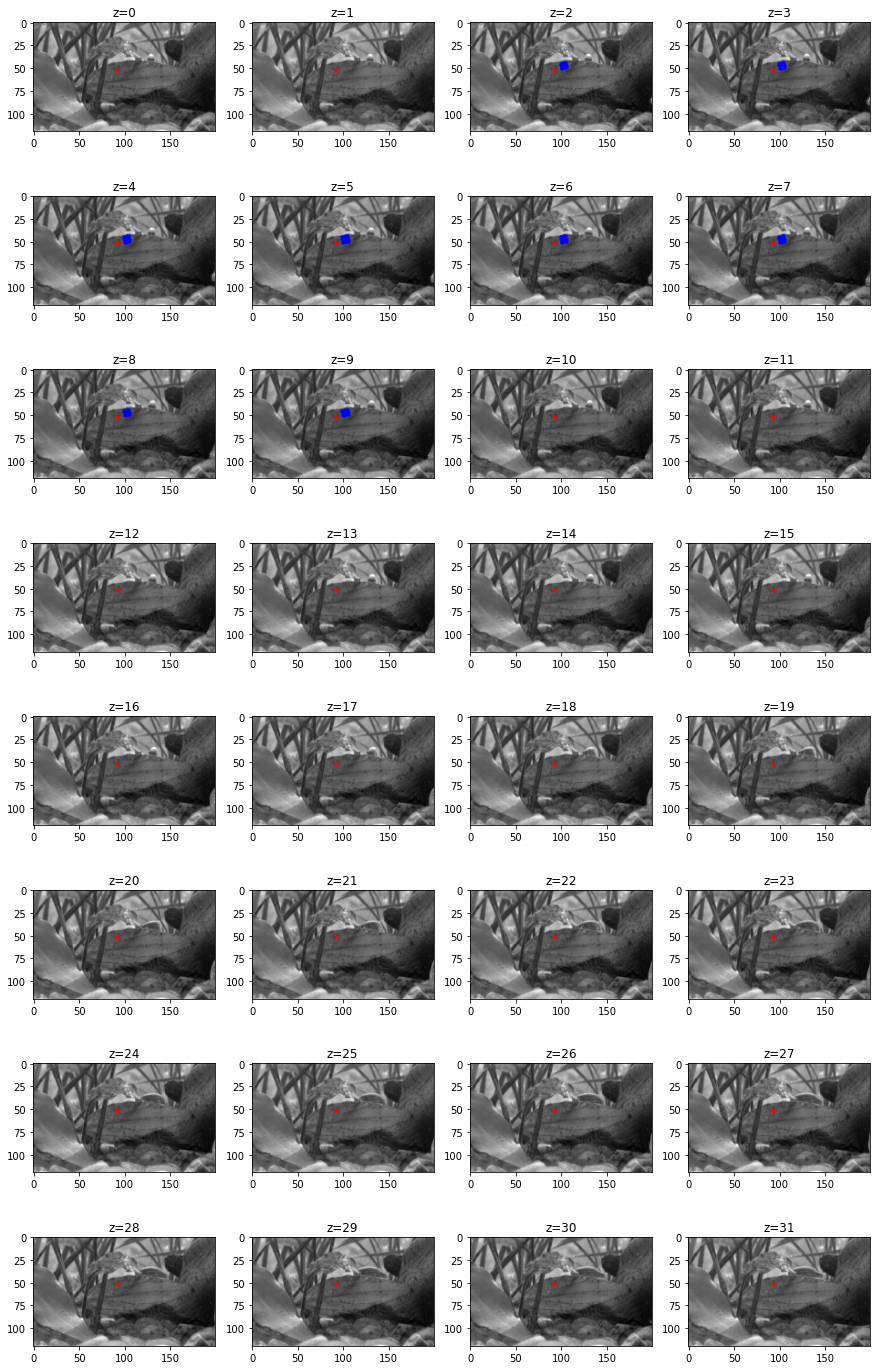

In [14]:
# visualize the frame batch as 32 two-dimentional frames
plt.figure(figsize=(15,25))
for n in range(batch_sz):
    ax = plt.subplot(8, 4, n+1)
    plt.imshow(sample_batch[n], cmap='gray')
    plt.title('z={}'.format(n))
    # plt.axis("off")
    # plt.axis("equal")
    
    # mark the correct region points on each frame
    for pt in zyx_list:
        if pt[0] == n:
            ax.plot((pt[2]), (pt[1]), 'o', color='b', markersize=1)
            
    # draw the keypoint's yx location on all frames
    ax.plot((kp_x), (kp_y), 'o', color='r', markersize=3)

plt.savefig('image/region_fv_'+str(desel_ind)+'_batch_'+str(batch_ind)+save_id+'.png',dpi=300, bbox_inches = "tight")

## Compute the descriptor element's orientation in the original coordinate system

The discriptor element's orientation is expressed as an index corresponding to a specific vertex in a regular icosahedron, in the rotated coordinate system.
<br>
To find the element's orientation in the original coordinate system, we rotate the vector connecting (0,0,0) to the specified icosahedron vertex by the keypoint's orientation.
<br>
Then, we compute the spherical coordinates ($\phi, \theta$) of the rotated vector.
<br>
This is the element's orientation in spherical coordinates in the original coordinate system.

In [15]:
PI = 3.1415926535897932 # pi
gr = (1 + np.sqrt(5)) / 2 # golden ratio

# coordinates of a regular icosahedron vertices
verts = [
          [0,  1,  gr], #0
          [0, -1,  gr], #1
          [0,  1, -gr], #2
          [0, -1, -gr], #3

          [ 1,  gr, 0], #4
          [-1,  gr, 0], #5
          [ 1, -gr, 0], #6
          [-1, -gr, 0], #7

          [ gr, 0,  1], #8
          [-gr, 0,  1], #9
          [ gr, 0, -1], #10
          [-gr, 0, -1], #11
        ]

In [16]:
print('Corresponding icosahedron vertex of desel:', desel_ori_rel)
print('Orientation of the keypoint:\n', kp_ori)

desel_ori_vect_rel = verts[desel_ori_rel]
print('Vector connecting the origin to the vertex of desel (in rotated coordinates):\n', desel_ori_vect_rel)

Corresponding icosahedron vertex of desel: 6
Orientation of the keypoint:
 [[-8.19300e-03 -1.40700e-03 -9.99965e-01]
 [-9.89901e-01 -1.41520e-01  8.31000e-03]
 [-1.41526e-01  9.89934e-01 -2.33000e-04]]
Vector connecting the origin to the vertex of desel (in rotated coordinates):
 [1, -1.618033988749895, 0]


In [17]:
# rotate desel's orientation by the keypoint's orientation
desel_ori_vect = kp_ori @ desel_ori_vect_rel
print('Vector connecting the origin to the vertex of desel (in original coordinates):\n', desel_ori_vect)

Vector connecting the origin to the vertex of desel (in original coordinates):
 [-0.00591643 -0.76091683 -1.74327286]


In [18]:
# compute theta and phi
dv_x, dv_y, dv_z = desel_ori_vect

In [19]:
# compute theta
theta_rad = math.atan(np.sqrt(dv_x**2 + dv_y**2) / (dv_z+1e-6))
theta_deg = np.round(theta_rad * 180 / PI, decimals=2)
if theta_deg < 0:
    theta_deg += 180

# compute phi
phi_rad = math.atan(dv_y / (dv_x+1e-6))
phi_deg = np.round(phi_rad * 180 / PI, decimals=2)
if phi_deg < 0 and dv_y < 0:
    phi_deg += 360
elif phi_deg < 0 and dv_y >= 0:
    phi_deg += 180
elif phi_deg >= 0 and dv_y < 0:
    phi_deg += 180

desel_ori_sphere = [theta_deg, phi_deg]
print('desel orientation in spherical coordinates in the original coordinate system:\ntheta=', 
      theta_deg, ' degrees,\tphi=', phi_deg, ' degrees')

np.savetxt('orientation/orient_fv_'+str(desel_ind)+'_batch_'+str(batch_ind)+save_id+'.csv', desel_ori_sphere)

desel orientation in spherical coordinates in the original coordinate system:
theta= 156.42000000000002  degrees,	phi= 269.55  degrees
